In [1]:
import os
from typing import Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Input

In [2]:
NUM_INPUTS = 96
NUM_OUTPUTS = 1
VAL_SPLIT = 0.1  # Percentage
BATCH_SIZE = 64
EPOCHS = 100
PATIENCE = 10  # Early stoping
LEARNING_RATE = 1e-4

In [3]:
def make_dataset(df: pd.DataFrame, shuffle: bool = True) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_tensor_slices(df.to_numpy())
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(lambda window: (window[:NUM_INPUTS], window[NUM_INPUTS:]))
    dataset = dataset.batch(batch_size=BATCH_SIZE, drop_remainder=False).prefetch(3)

    return dataset


def get_compiled_model(
    input_shape: Sequence[int],
    num_outputs: int,
    hidden: Sequence[int] = (100, 100, 100),
    activation: str = "relu",
    lr: float = 1e-3,
    batch_norm: bool = True,
) -> keras.Model:
    model = tf.keras.Sequential()
    model.add(Input(shape=input_shape))
    if batch_norm:
        model.add(BatchNormalization())
    for h_units in hidden:
        model.add(Dense(h_units, activation="relu"))
    model.add(Dense(num_outputs))

    model.compile(
        optimizer=keras.optimizers.Adam(lr=lr),
        loss=keras.losses.mse,
        metrics=[keras.metrics.mse],
    )

    return model


def mse(a: np.array, b: np.array) -> float:
    return np.mean(np.square(a - b))


def mae(a: np.array, b: np.array) -> float:
    return np.mean(np.abs(a - b))


def smape(a: np.array, b: np.array) -> float:
    num = np.abs(b - a)
    den = np.abs(a) + np.abs(b)
    sum = np.where(den == 0, 0, num / den)
    return sum.mean()


def scale_dataframe(
    df: pd.DataFrame, cols: Sequence[str] = None, new_max: int = 1, new_min: int = -1
) -> None:
    cols = cols or df.columns
    for col in cols:
        col_max = df[col].max()
        col_min = df[col].min()
        df[col] = new_min + ((df[col] - col_min) * (new_max - new_min)) / (
            col_max - col_min
        )
        assert df[col].min() == new_min
        assert df[col].max() == new_max


def read_csv(path: str, scale: bool = False, **kwargs) -> pd.DataFrame:
    drop_cols = [f"y{i}" for i in range(NUM_OUTPUTS, 48)]  # drop unnecessary outputs
    drop_cols.append("Unnamed: 0")
    df = pd.read_csv(path)
    df.drop(columns=drop_cols, inplace=True)

    if scale:
        print(f"Scaling {path} . . .")
        input_cols = [f"x{i}" for i in range(96)]
        scale_dataframe(df, input_cols, **kwargs)

    return df

# Forecasting Unscaled Orignal Dataset

### Preparing dataset

In [4]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=False)
df_test = read_csv("data/amarillo_norm_test.csv", scale=False)
targets = df_test["y0"].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

### Training

In [5]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 16698.2930 - mean_squared_error: 16698.2930 - val_loss: 10646.8115 - val_mean_squared_error: 10646.8115
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 6509.6333 - mean_squared_error: 6509.6333 - val_loss: 10190.3877 - val_mean_squared_error: 10190.3877
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5721.3911 - mean_squared_error: 5721.3911 - val_loss: 9479.6982 - val_mean_squared_error: 9479.6982
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5302.6602 - mean_squared_error: 5302.6602 - val_loss: 9173.2754 - val_mean_squared_error: 9173.2754
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5051.5894 - mean_squared_error: 5051.5894 - val_loss: 9166.7646 - val_mean_squared_error: 9166.7646
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 4835.7090 - mean_squared_e

### Testing

In [6]:
preds = model.predict(ds_test)
preds = preds.T[0]
preds_unscaled = preds.copy()

In [7]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 7230.111958649607
MAE 48.83670637773143
SMAPE 0.6213605853369467


In [8]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

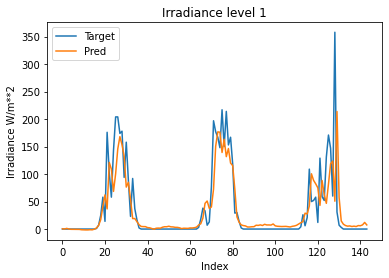

In [9]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

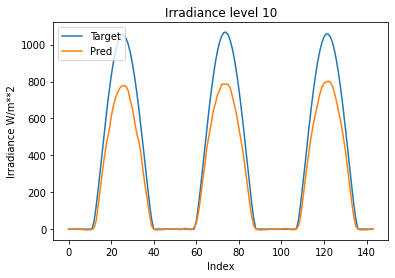

In [10]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Original Dataset
Scaled to -> [0, 1]

### Preparing dataset

In [11]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=True, new_min = 0, new_max = 1)
df_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = 0, new_max = 1)
targets = df_test["y0"].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_norm_train.csv . . .
Scaling data/amarillo_norm_test.csv . . .


In [12]:
df_train['x0'].max()

1.0

In [13]:
df_train['x0'].min()

0.0

### Training

In [14]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 16444.2617 - mean_squared_error: 16444.2617 - val_loss: 10724.1729 - val_mean_squared_error: 10724.1729
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 6631.6274 - mean_squared_error: 6631.6274 - val_loss: 11142.6582 - val_mean_squared_error: 11142.6582
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5852.9478 - mean_squared_error: 5852.9478 - val_loss: 9116.5527 - val_mean_squared_error: 9116.5527
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5395.8232 - mean_squared_error: 5395.8232 - val_loss: 8967.2783 - val_mean_squared_error: 8967.2783
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5112.9849 - mean_squared_error: 5112.9849 - val_loss: 10038.3174 - val_mean_squared_error: 10038.3174
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 4965.7764 - mean_squared

### Testing

In [15]:
preds = model.predict(ds_test)
preds = preds.T[0]
preds_scaled = preds.copy()

In [16]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 6675.631658693168
MAE 46.271641561989156
SMAPE 0.6144418167488497


In [17]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

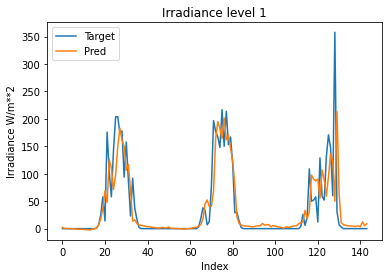

In [18]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

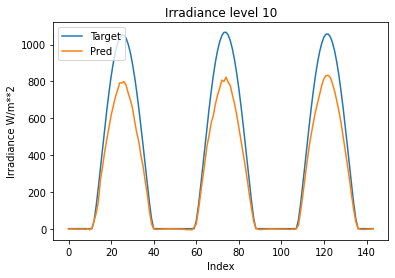

In [19]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Original Dataset
Scaled to -> [-1, 1]

### Preparing dataset

In [20]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=True, new_min = -1, new_max = 1)
df_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = -1, new_max = 1)
targets = df_test["y0"].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_norm_train.csv . . .
Scaling data/amarillo_norm_test.csv . . .


In [21]:
df_train['x0'].max()

1.0

In [22]:
df_train['x0'].min()

-1.0

### Training

In [23]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 16784.4297 - mean_squared_error: 16784.4297 - val_loss: 10905.6816 - val_mean_squared_error: 10905.6816
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 6377.8037 - mean_squared_error: 6377.8037 - val_loss: 9313.5967 - val_mean_squared_error: 9313.5967
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5612.8242 - mean_squared_error: 5612.8242 - val_loss: 9665.3604 - val_mean_squared_error: 9665.3604
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5259.2373 - mean_squared_error: 5259.2373 - val_loss: 9558.8945 - val_mean_squared_error: 9558.8945
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 5033.7505 - mean_squared_error: 5033.7505 - val_loss: 9396.6543 - val_mean_squared_error: 9396.6543
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 4810.3716 - mean_squared_err

### Testing

In [24]:
preds = model.predict(ds_test)
preds = preds.T[0]
preds_scaled_neg = preds.copy()

In [25]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 6827.846011746258
MAE 46.707054814841186
SMAPE 0.624029664847925


In [26]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

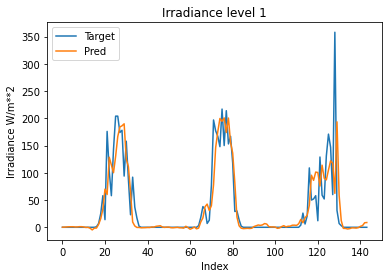

In [27]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

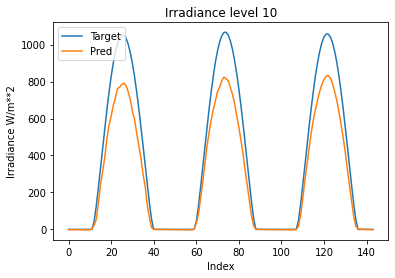

In [28]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Unscaled Differences Dataset

### Preparing dataset

In [29]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=False)
df_test = read_csv("data/amarillo_diff_test.csv", scale=False)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=False)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

### Training

In [30]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 4133.4468 - mean_squared_error: 4133.4468 - val_loss: 2549.3765 - val_mean_squared_error: 2549.3765
Epoch 2/100
5155/5155 [==============================] - 11s 2ms/step - loss: 3259.4500 - mean_squared_error: 3259.4500 - val_loss: 2530.4885 - val_mean_squared_error: 2530.4885
Epoch 3/100
5155/5155 [==============================] - 11s 2ms/step - loss: 3197.7065 - mean_squared_error: 3197.7065 - val_loss: 2483.5789 - val_mean_squared_error: 2483.5789
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3160.2336 - mean_squared_error: 3160.2336 - val_loss: 2441.8306 - val_mean_squared_error: 2441.8306
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3146.5356 - mean_squared_error: 3146.5356 - val_loss: 2402.0688 - val_mean_squared_error: 2402.0688
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3125.7627 - mean_squared_error: 

### Testing

In [31]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_unscaled = preds.copy()

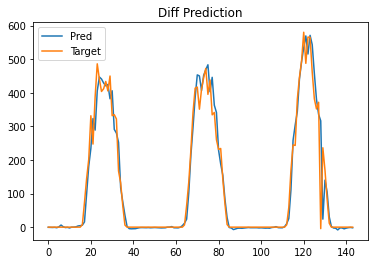

In [32]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [33]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 1870.0894034898206
MAE 17.935002996370464
SMAPE 0.5781861089431134


In [34]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

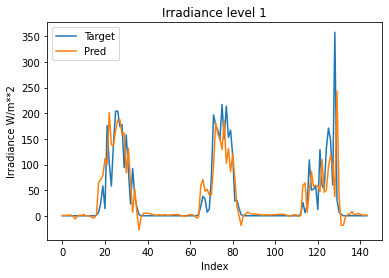

In [35]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

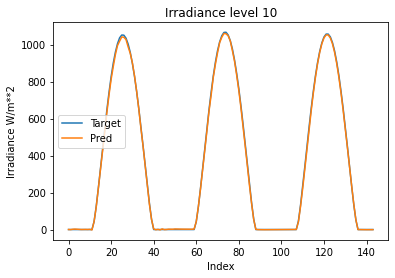

In [36]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Differences Dataset
Scaled -> [0, 1]

### Preparing dataset

In [37]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=True, new_min = 0, new_max = 1)
df_test = read_csv("data/amarillo_diff_test.csv", scale=True, new_min = 0, new_max = 1)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = 0, new_max = 1)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_diff_train.csv . . .
Scaling data/amarillo_diff_test.csv . . .
Scaling data/amarillo_norm_test.csv . . .


In [38]:
print(f"{df_train['x0'].min()},{df_train['x0'].max()}")
print(f"{df_test['x0'].min()},{df_test['x0'].max()}")
print(f"{df_orig_test['x0'].min()},{df_orig_test['x0'].max()}")

0.0,1.0
0.0,1.0
0.0,1.0


### Training

In [39]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 4031.3354 - mean_squared_error: 4031.3354 - val_loss: 2509.0862 - val_mean_squared_error: 2509.0862
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3058.0120 - mean_squared_error: 3058.0120 - val_loss: 2430.3540 - val_mean_squared_error: 2430.3540
Epoch 3/100
5155/5155 [==============================] - 11s 2ms/step - loss: 2982.2524 - mean_squared_error: 2982.2524 - val_loss: 2441.3757 - val_mean_squared_error: 2441.3757
Epoch 4/100
5155/5155 [==============================] - 11s 2ms/step - loss: 2990.2881 - mean_squared_error: 2990.2881 - val_loss: 2360.3110 - val_mean_squared_error: 2360.3110
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2968.0957 - mean_squared_error: 2968.0957 - val_loss: 2399.0061 - val_mean_squared_error: 2399.0061
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2995.4685 - mean_squared_error: 

### Testing

In [40]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_scaled = preds.copy()

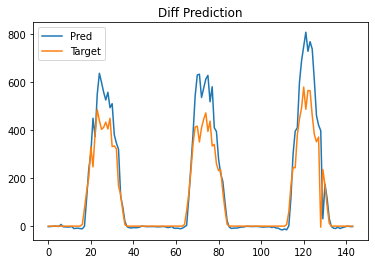

In [41]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [42]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 3614.424223858286
MAE 31.822405659789542
SMAPE 0.617983432390896


In [43]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

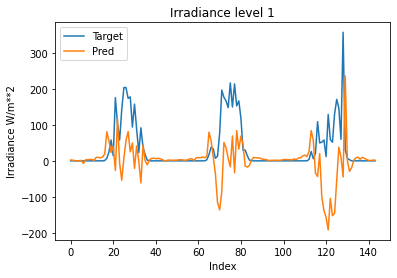

In [44]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

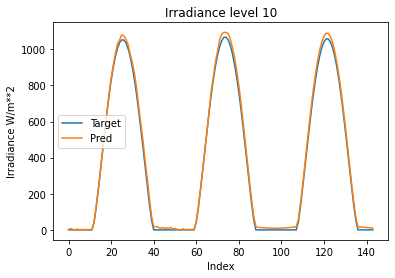

In [45]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Differences Dataset
Scaled -> [-1, 1]

### Preparing dataset

In [46]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=True, new_min = -1, new_max = 1)
df_test = read_csv("data/amarillo_diff_test.csv", scale=True, new_min = -1, new_max = 1)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = -1, new_max = 1)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_diff_train.csv . . .
Scaling data/amarillo_diff_test.csv . . .
Scaling data/amarillo_norm_test.csv . . .


### Training

In [47]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 4140.2788 - mean_squared_error: 4140.2788 - val_loss: 2535.5129 - val_mean_squared_error: 2535.5129
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3215.0662 - mean_squared_error: 3215.0662 - val_loss: 2404.7026 - val_mean_squared_error: 2404.7026
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3174.3726 - mean_squared_error: 3174.3726 - val_loss: 2412.8271 - val_mean_squared_error: 2412.8271
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3136.9004 - mean_squared_error: 3136.9004 - val_loss: 2402.7612 - val_mean_squared_error: 2402.7612
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3093.2063 - mean_squared_error: 3093.2063 - val_loss: 2375.4358 - val_mean_squared_error: 2375.4358
Epoch 6/100
5155/5155 [==============================] - 11s 2ms/step - loss: 3132.3611 - mean_squared_error: 

### Testing

In [48]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_scaled_neg = preds.copy()

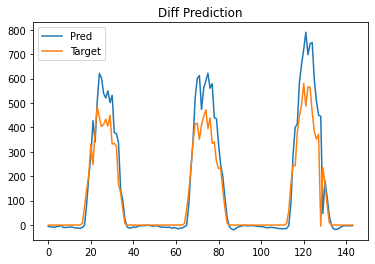

In [49]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [50]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 3473.368577092031
MAE 32.837405033836106
SMAPE 0.6163393960732045


In [51]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

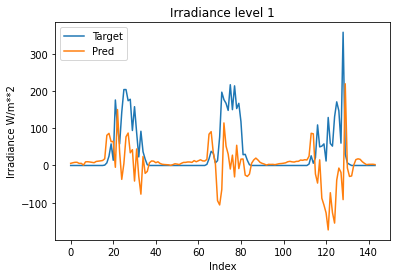

In [52]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

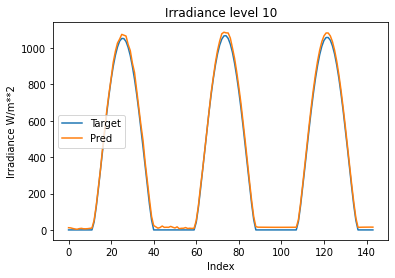

In [53]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Summary

In [54]:
print('Original Unscaled')
print(f"MSE {mse(targets, preds_unscaled)}")
print(f"MAE {mae(targets, preds_unscaled)}")
print(f"SMAPE {smape(targets, preds_unscaled)}")

Original Unscaled
MSE 74559.49801041631
MAE 149.61019791300194
SMAPE 0.8676888786767888


In [55]:
print('Original Scaled (0, 1)')
print(f"MSE {mse(targets, preds_scaled)}")
print(f"MAE {mae(targets, preds_scaled)}")
print(f"SMAPE {smape(targets, preds_scaled)}")

Original Scaled (0, 1)
MSE 75817.29209521071
MAE 151.36938054263203
SMAPE 0.8693709533191782


In [56]:
print('Original Scaled (-1, 1)')
print(f"MSE {mse(targets, preds_scaled_neg)}")
print(f"MAE {mae(targets, preds_scaled_neg)}")
print(f"SMAPE {smape(targets, preds_scaled_neg)}")

Original Scaled (-1, 1)
MSE 74979.40371993928
MAE 149.19719384872067
SMAPE 0.8688484356230695


In [57]:
print('Differences Unscaled')
print(f"MSE {mse(targets_orig, preds_diff_unscaled)}")
print(f"MAE {mae(targets_orig, preds_diff_unscaled)}")
print(f"SMAPE {smape(targets_orig, preds_diff_unscaled)}")

Differences Unscaled
MSE 1870.0894034898206
MAE 17.935002996370464
SMAPE 0.5781861089431134


In [58]:
print('Differences Scaled (0, 1)')
print(f"MSE {mse(targets_orig, preds_diff_scaled)}")
print(f"MAE {mae(targets_orig, preds_diff_scaled)}")
print(f"SMAPE {smape(targets_orig, preds_diff_scaled)}")

Differences Scaled (0, 1)
MSE 3614.424223858286
MAE 31.822405659789542
SMAPE 0.617983432390896


In [59]:
print('Differences Scaled (-1, 1)')
print(f"MSE {mse(targets_orig, preds_diff_scaled_neg)}")
print(f"MAE {mae(targets_orig, preds_diff_scaled_neg)}")
print(f"SMAPE {smape(targets_orig, preds_diff_scaled_neg)}")

Differences Scaled (-1, 1)
MSE 3473.368577092031
MAE 32.837405033836106
SMAPE 0.6163393960732045
